In [1]:
import sys

sys.path.append("../../")

In [ ]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch
from preprocessing_cnn import GrayscaleAndFlattenPreprocessing, PreprocessingCNN
import matplotlib.pyplot as plt
from matplotlib import axes
from graph_utils import plot_probability_distribution_on_ax


### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

shapes = [(5, 5, 5), (8, 8, 8)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env_cnn, limits = make_env()
env_no_cnn, limits = make_env()
model_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)
model_no_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=60 * 80,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)

#### preprocessor
cnn_preproc = PreprocessingCNN(
    device=device,
    latent_dim=128,
    input_channels=3,
    target_size=(224, 224),
    model_path="resnet18_adapter.pth",
)

grayscale_flatten_preproc = GrayscaleAndFlattenPreprocessing(device=device)

#### agents
agent_cnn = MiniworldVectorhashAgent(model_cnn, env_cnn, preprocessor=cnn_preproc)

agent_no_cnn = MiniworldVectorhashAgent(
    model_no_cnn, env_no_cnn, preprocessor=grayscale_flatten_preproc
)

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:4: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import norm


by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../hippocampal_sensory_layers.py:110: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered int

info for each h directly after learning it
h max, min, mean tensor(5.9848, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7899, device='cuda:0')
h_from_s max, min, mean tensor(5.9830, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7894, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0773, device='cuda:0') tensor(1.4139, device='cuda:0') tensor(1.7229, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(531, device='cuda:0') tensor(531, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(531, device='cuda:0') tensor(531, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(4.0463e-07, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.6918, device='cuda:0') tensor([0.8099], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(2.8418e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.S

info for each h directly after learning it
h max, min, mean tensor(5.6570, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8163, device='cuda:0')
h_from_s max, min, mean tensor(5.6570, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8163, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0235, device='cuda:0') tensor(1.4055, device='cuda:0') tensor(1.7238, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(536, device='cuda:0') tensor(536, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(536, device='cuda:0') tensor(536, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(1.0957e-10, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.5078, device='cuda:0') tensor([0.8293], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(1.1601e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the input size (torch.

In [3]:
start_state = agent_no_cnn.vectorhash.scaffold.g
print("start state:", start_state)
print("grid limits:", agent_no_cnn.vectorhash.scaffold.grid_limits)
print("world limits:", limits)
print("scale factor:", agent_no_cnn.vectorhash.scaffold.scale_factor)

start state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [4]:
begin = agent_no_cnn.get_true_pos(env_no_cnn)
end = begin + 1 / agent_no_cnn.vectorhash.scaffold.scale_factor
dist = torch.distributions.uniform.Uniform(low=begin, high=end)
samples = dist.sample((N,))
grid_states = agent_no_cnn.vectorhash.scaffold.scale_factor * (samples - begin)

In [5]:
print("samples:", samples)
print("grid states:", grid_states)

samples: tensor([[ 2.5601, 14.3920, -0.9167],
        [ 2.8135, 14.2951, -0.9026],
        [ 2.5492, 14.4262, -0.9975],
        [ 2.8321, 14.4392, -0.9014],
        [ 2.6154, 14.4246, -1.0066],
        [ 2.5549, 14.3171, -0.9852],
        [ 2.8449, 14.3959, -0.9605],
        [ 2.5146, 14.4490, -0.8953],
        [ 2.7673, 14.2915, -0.9972],
        [ 2.6387, 14.5290, -1.0064]], device='cuda:0')
grid states: tensor([[0.2585, 0.6391, 0.7582],
        [0.8920, 0.3968, 0.8483],
        [0.2313, 0.7247, 0.2439],
        [0.9386, 0.7571, 0.8560],
        [0.3968, 0.7207, 0.1861],
        [0.2456, 0.4519, 0.3224],
        [0.9705, 0.6489, 0.4794],
        [0.1448, 0.7818, 0.8949],
        [0.7766, 0.3879, 0.2458],
        [0.4551, 0.9816, 0.1874]], device='cuda:0')


info for each h directly after learning it
h max, min, mean tensor(5.6570, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8163, device='cuda:0')
h_from_s max, min, mean tensor(5.6570, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8163, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0235, device='cuda:0') tensor(1.4055, device='cuda:0') tensor(1.7238, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(536, device='cuda:0') tensor(536, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(536, device='cuda:0') tensor(536, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.6702e-11, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.5078, device='cuda:0') tensor([0.8293], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(2.9139e-11, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:132: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:139: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input

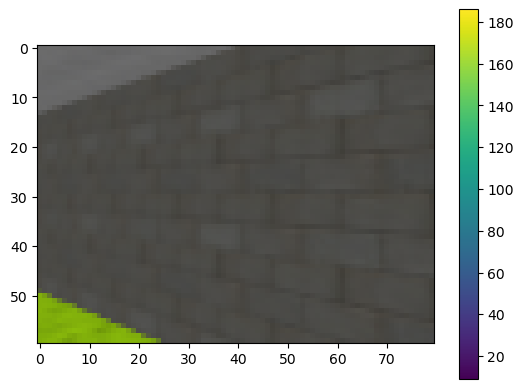

In [6]:
first_img, first_pos = agent_no_cnn._env_reset(env_cnn)
first_img, first_pos = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
m = plt.imshow(first_img)
plt.colorbar(m)
agent_no_cnn.vectorhash.store_memory(s=agent_no_cnn.preprocessor.encode(first_img))
agent_cnn.vectorhash.store_memory(s=agent_cnn.preprocessor.encode(first_img))

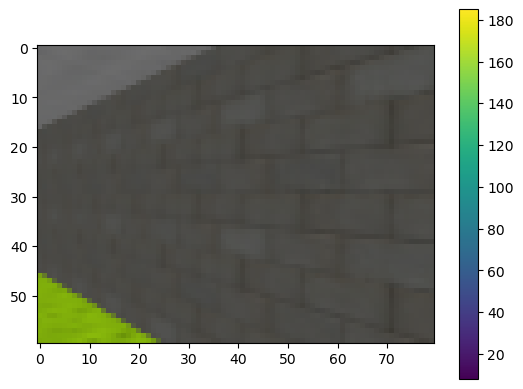

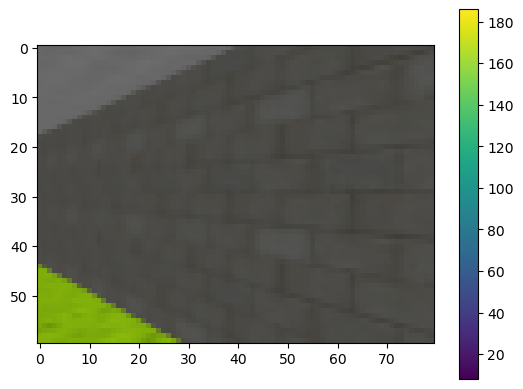

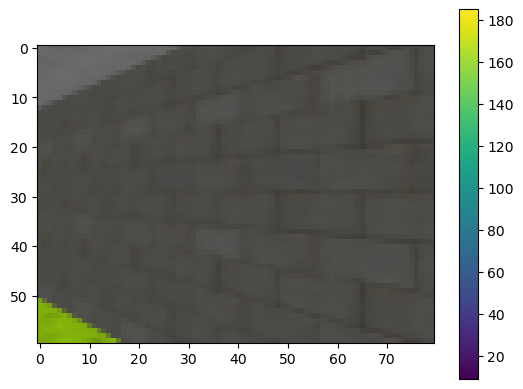

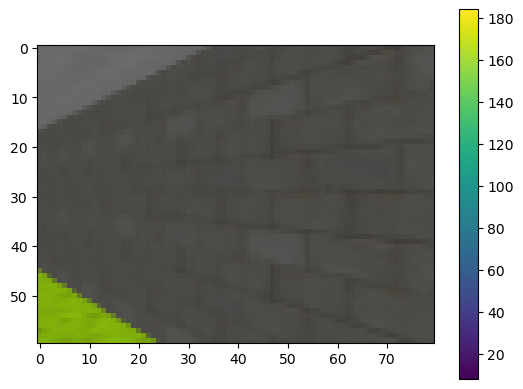

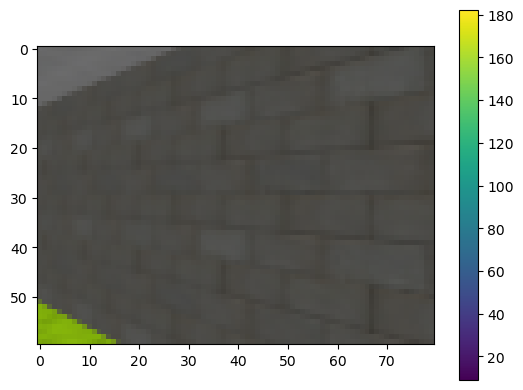

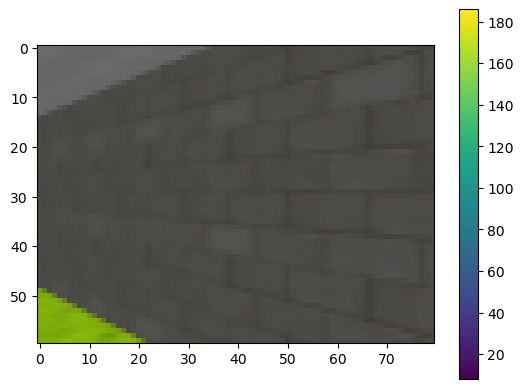

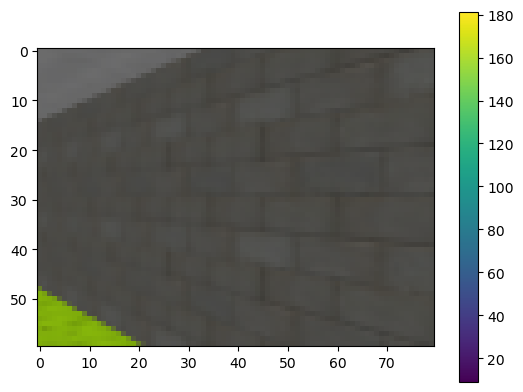

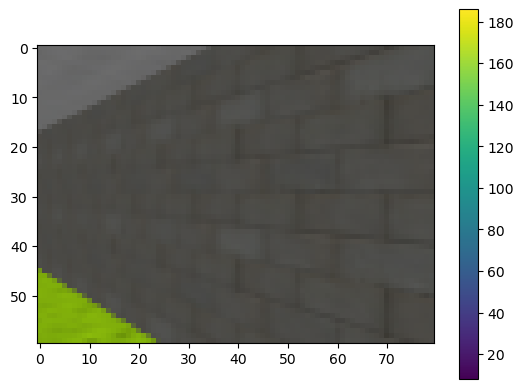

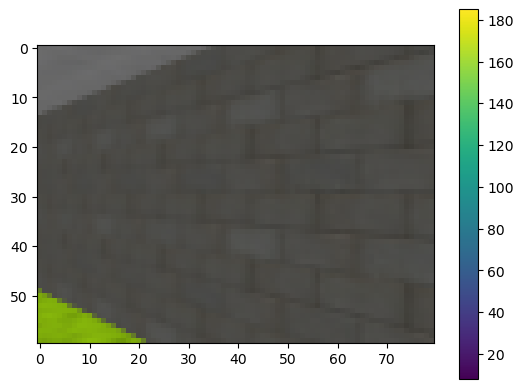

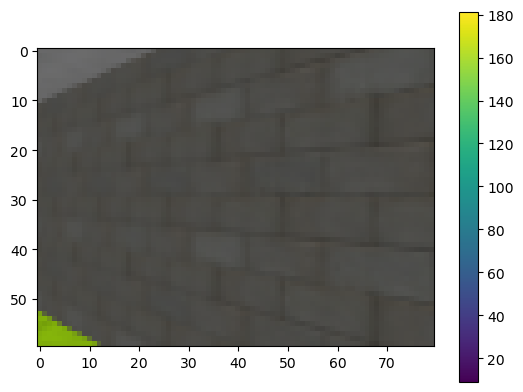

In [7]:
imgs = []
states_cnn = []
states_no_cnn = []
for sample in samples:
    pos = sample.cpu().numpy()
    agent_no_cnn.set_agent_pos(pos)
    agent_cnn.set_agent_pos(pos)
    img, _ = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
    obs_cnn = agent_cnn.preprocessor.encode(img)
    obs_no_cnn = agent_no_cnn.preprocessor.encode(img)
    g_cnn = agent_cnn.vectorhash.scaffold.denoise(
        agent_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_cnn
            )
        )
    )
    g_no_cnn = agent_no_cnn.vectorhash.scaffold.denoise(
        agent_no_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_no_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_no_cnn
            )
        )
    )
    m = plt.imshow(img)
    plt.colorbar(m)
    plt.show()
    imgs.append(img)
    states_cnn.append(g_cnn)
    states_no_cnn.append(g_no_cnn)

Text(0.5, 0.98, 'probability mass in each distribution (cnn)')

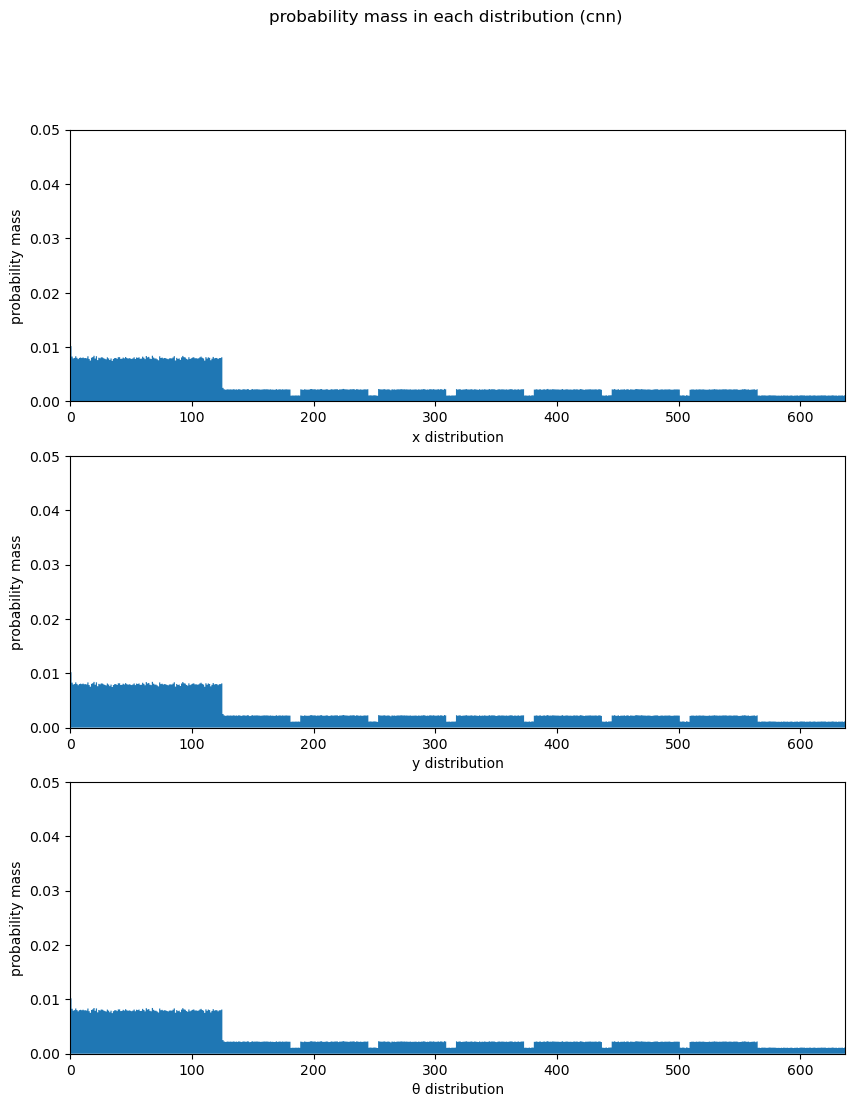

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

plot_probability_distribution_on_ax(states_cnn[0][0].cpu(), axs[0])
plot_probability_distribution_on_ax(states_cnn[1][0].cpu(), axs[1])
plot_probability_distribution_on_ax(states_cnn[2][0].cpu(), axs[2])

for i in range(3):
  a: axes.Axes = axs[i]
  a.set_ylim(0, 0.05)
  a.set_xlim(0, len(states_cnn[0][0]))
  a.set_ylabel('probability mass')
  
axs[0].set_xlabel('x distribution')
axs[1].set_xlabel('y distribution')
axs[2].set_xlabel('θ distribution')

fig.suptitle('probability mass in each distribution (cnn)')

In [ ]:
fig.savefig('results_cnn.png')

Text(0.5, 0.98, 'probability mass in each distribution (no cnn)')

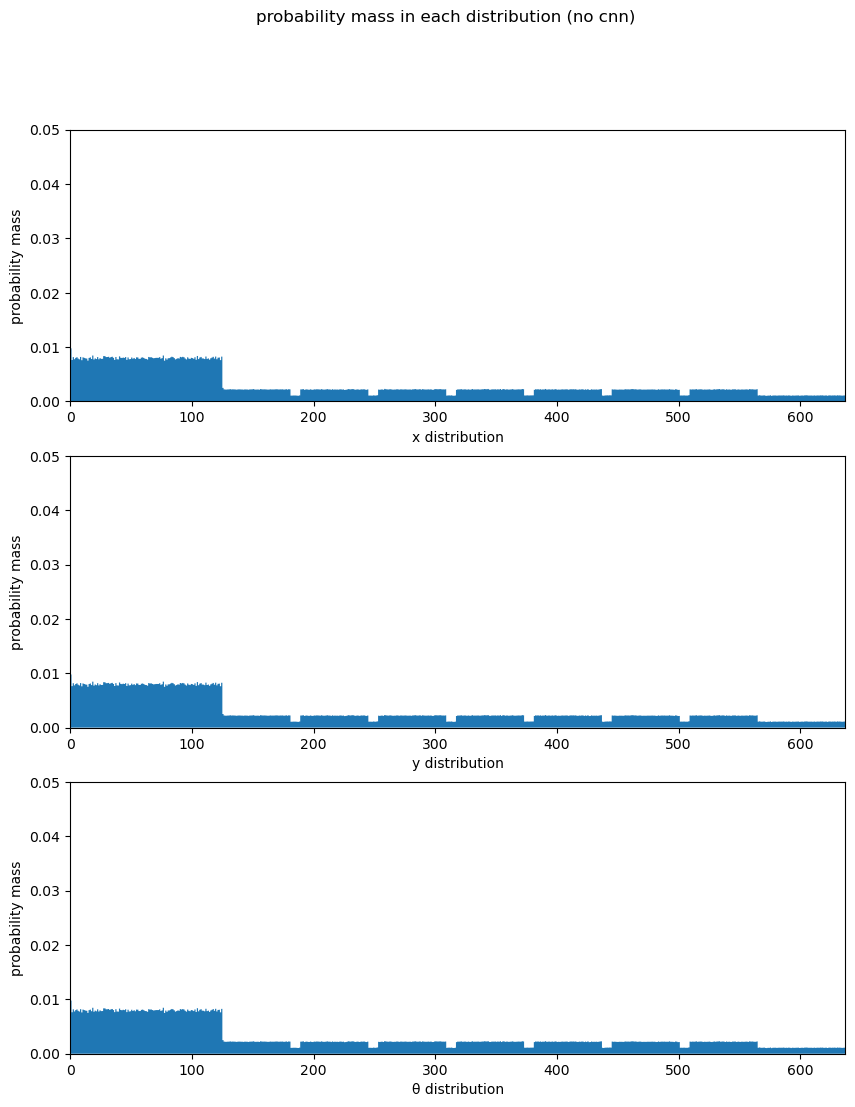

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

plot_probability_distribution_on_ax(states_no_cnn[0][0].cpu(), axs[0])
plot_probability_distribution_on_ax(states_no_cnn[1][0].cpu(), axs[1])
plot_probability_distribution_on_ax(states_no_cnn[2][0].cpu(), axs[2])

for i in range(3):
  a: axes.Axes = axs[i]
  a.set_ylim(0, 0.05)
  a.set_xlim(0, len(states_cnn[0][0]))
  a.set_ylabel('probability mass')
  
axs[0].set_xlabel('x distribution')
axs[1].set_xlabel('y distribution')
axs[2].set_xlabel('θ distribution')

fig.suptitle('probability mass in each distribution (no cnn)')

In [10]:
fig.savefig('results_no_cnn.png')